<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/master/assets/polynomial_basis_stat_props.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import numpy as np
from numpy.polynomial.chebyshev import chebvander
from numpy.polynomial.legendre import legvander
from numpy.polynomial.polynomial import polyvander, Polynomial
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom as binom_dist
import pandas as pd

In [70]:
def bernvander(x, deg, lb=-1, ub=1):
  x = np.array(x)
  x = np.clip((x - lb) / (ub - lb), lb, ub)
  return binom_dist.pmf(np.arange(1 + deg), deg, x.reshape(-1, 1))

### Define function to fit

In [71]:
def f(x):
  first = np.sin(np.pi * (x + np.abs(x - 0.75) ** 1.5))
  second = np.cos(0.8 * np.pi * (np.abs(x + 0.75) ** 1.5 - x)) + 0.5
  return 2 * np.minimum(first, second)

In [72]:
plot_n = 10000
plot_xs = np.linspace(-1, 1, plot_n)

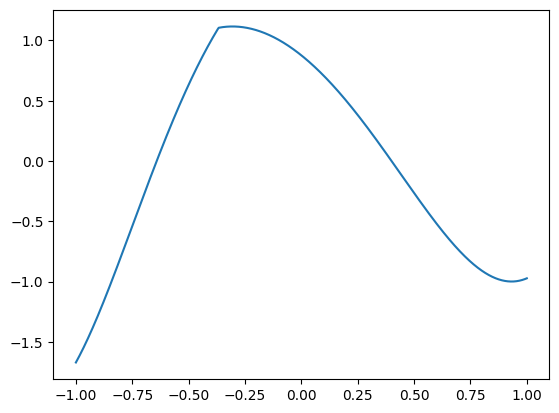

In [73]:
plt.plot(plot_xs, f(plot_xs))
plt.show()

### Fit various polynomials at random points and plot them

In [74]:
def fit_eval(vander_fn, eval_at, deg=20, n=40, reg_coef=0., ax=None, **plot_kws):
  # sample points for fitting
  xs = np.random.uniform(-1, 1, n)
  ys = f(xs)

  # build matrix and vector for least-squares regression
  vander_mat = vander_fn(xs, deg)
  if reg_coef > 0:
    coef_mat = np.identity(1 + deg) * np.sqrt(reg_coef)
    vander_mat = np.concatenate([vander_mat, coef_mat], axis=0)
    ys = np.concatenate([ys, np.zeros(1 + deg)], axis=-1)

  # compute polynomial coefficients
  coef, residuals, rank, sigma = np.linalg.lstsq(vander_mat, ys, rcond=None)

  # evaluate the polynomial at `eval_at`
  return vander_fn(eval_at, deg) @ coef

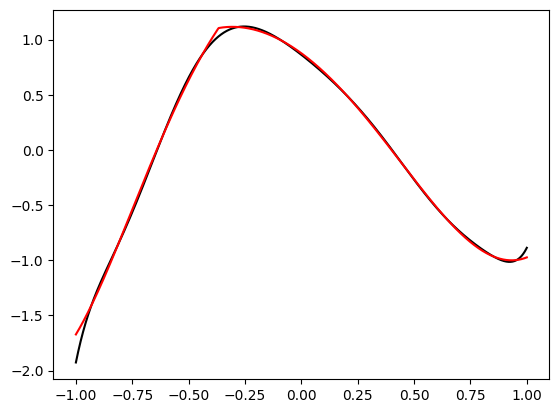

In [75]:
ys = fit_eval(polyvander, plot_xs, deg=10)
plt.plot(plot_xs, ys, color='k')
plt.plot(plot_xs, f(plot_xs), color='r')
plt.show()

In [76]:
def fit_eval_samples(eval_at, vander_fn, n_iter=1000, **fit_eval_kwargs):
  y_samples = []
  for i in range(n_iter):
    ys = fit_eval(vander_fn, eval_at, **fit_eval_kwargs)
    y_samples.append(ys)
  y_samples = np.vstack(y_samples)
  y_true = f(eval_at)
  return y_samples, y_true

## Bias and variance visualization

In [77]:
def plot_basis_fits(n_iter, vander_fn, ylim=[-3, 3], alpha=0.1, ax=None, **fit_eval_kwargs):
  ax = ax or plt.gca()
  plot_xs = np.linspace(-1, 1, 10000)
  samples, y_true = fit_eval_samples(plot_xs, vander_fn, n_iter, **fit_eval_kwargs)
  mean_poly = np.mean(samples, axis=0)
  ax.plot(plot_xs, samples.T, 'r', alpha=alpha)
  ax.plot(plot_xs, mean_poly, color='blue', linewidth=2.)
  ax.plot(plot_xs, y_true, 'k--')
  ax.set_ylim(ylim)

In [78]:
def plot_all_bases(**plot_loop_kwargs):
  fig, axs = plt.subplots(2, 2, figsize=(10, 8))

  plot_basis_fits(100, polyvander, ax=axs[0, 0], **plot_loop_kwargs)
  axs[0, 0].set_title('Standard')

  plot_basis_fits(100, chebvander, ax=axs[0, 1], **plot_loop_kwargs)
  axs[0, 1].set_title('Chebyshev')

  plot_basis_fits(100, legvander, ax=axs[1, 0], **plot_loop_kwargs)
  axs[1, 0].set_title('Legendre')

  plot_basis_fits(100, bernvander, ax=axs[1, 1], **plot_loop_kwargs)
  axs[1, 1].set_title('Bernstein')

  plt.show()

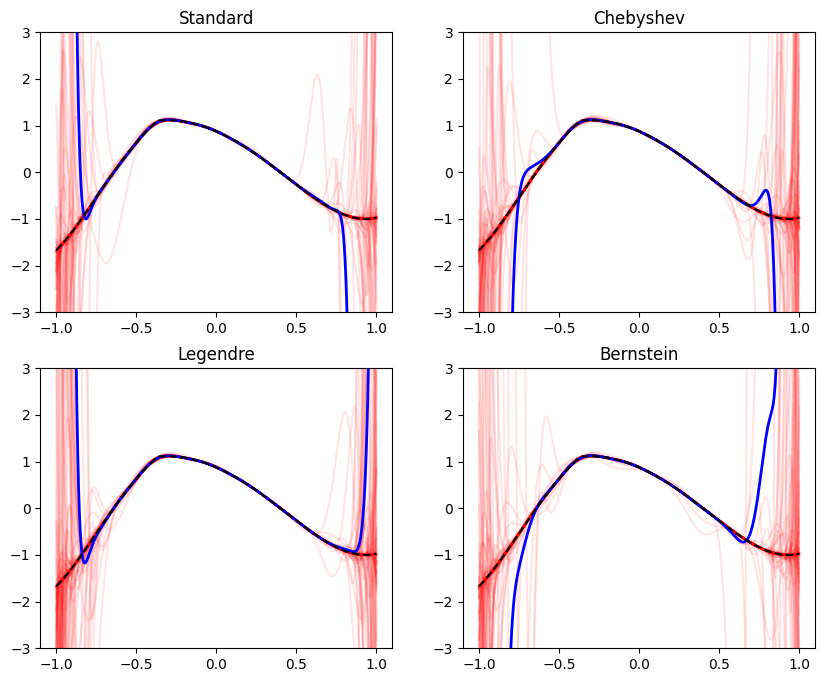

In [79]:
plot_all_bases(reg_coef=0.)

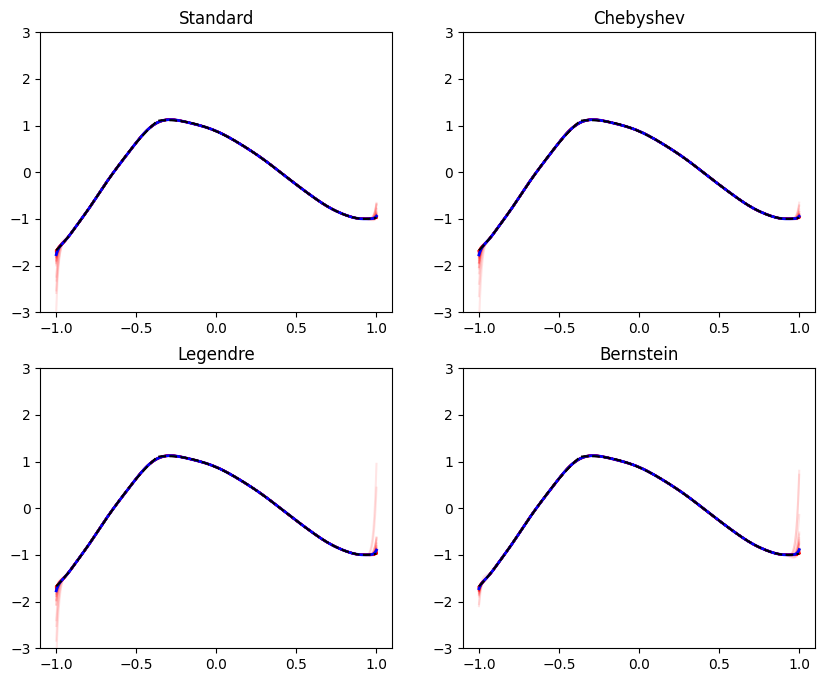

In [80]:
plot_all_bases(n=200, reg_coef=0.)

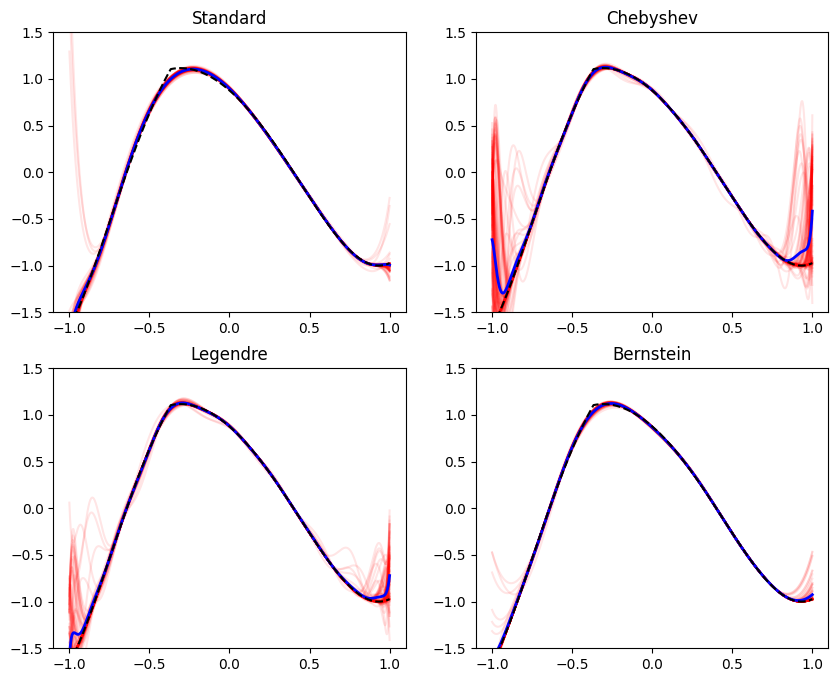

In [81]:
plot_all_bases(reg_coef=1e-3, ylim=[-1.5, 1.5])

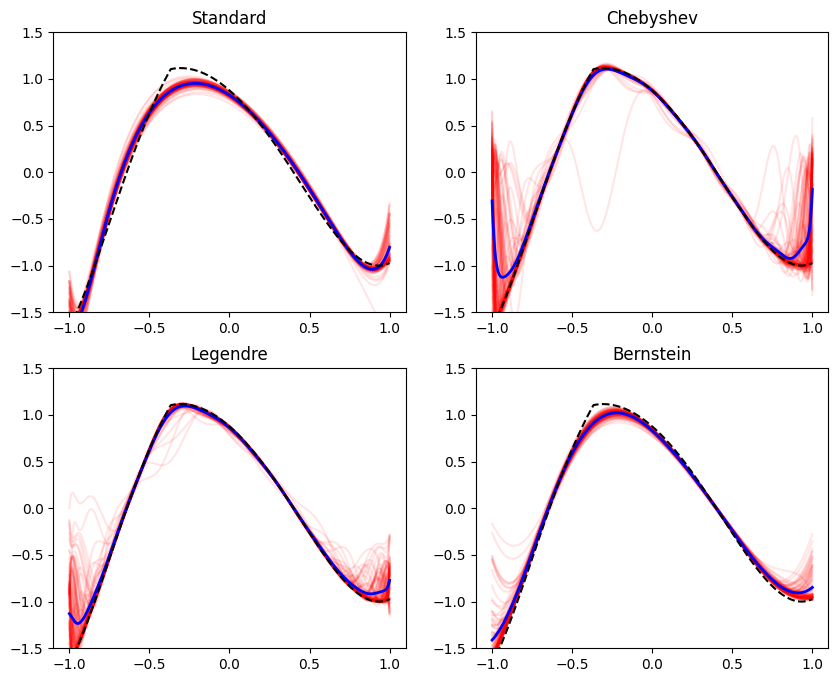

In [82]:
plot_all_bases(reg_coef=1e-1, ylim=[-1.5, 1.5])

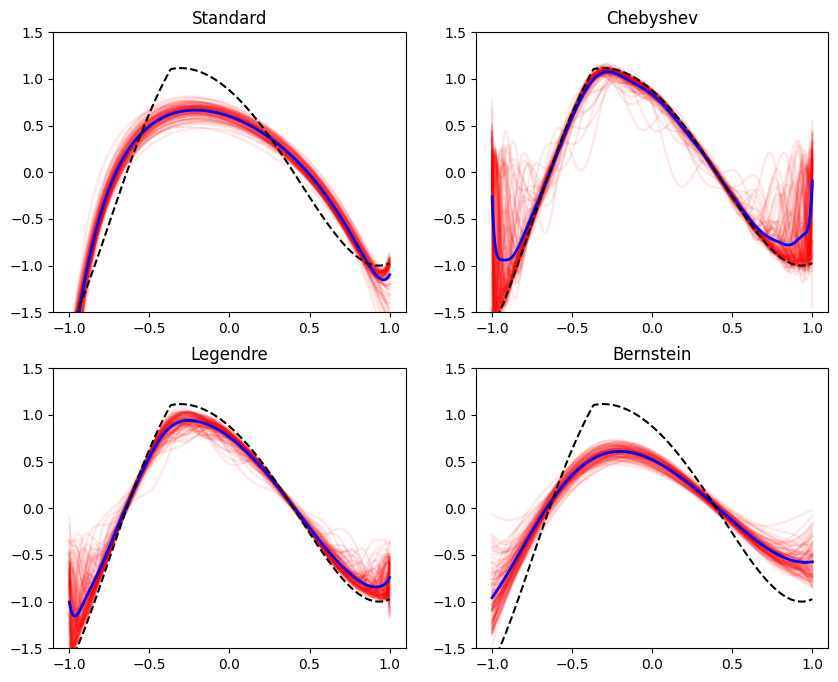

In [83]:
plot_all_bases(reg_coef=1, ylim=[-1.5, 1.5])

# Bias-variance tradeoff analysis

In [84]:
def bias_variance_tradeoff(vander_fn, reg_coefs, nx=1000, **fit_eval_kwargs):
  xs = np.linspace(-1, 1, nx)
  biases = []
  vars = []
  for reg_coef in reg_coefs:
    y_samples, y_true = fit_eval_samples(xs, vander_fn, reg_coef=reg_coef, **fit_eval_kwargs)
    bias_agg = np.mean((np.mean(y_samples, axis=0) - y_true) ** 2)
    variance_agg = np.mean(np.var(y_samples, axis=0))
    biases.append(bias_agg)
    vars.append(variance_agg)

  return biases, vars

In [85]:
reg_coefs = np.geomspace(1e-8, 1e2, 64)
reg_coefs

array([1.00000000e-08, 1.44121960e-08, 2.07711393e-08, 2.99357729e-08,
       4.31440226e-08, 6.21800109e-08, 8.96150502e-08, 1.29154967e-07,
       1.86140669e-07, 2.68269580e-07, 3.86635375e-07, 5.57226480e-07,
       8.03085722e-07, 1.15742288e-06, 1.66810054e-06, 2.40409918e-06,
       3.46483486e-06, 4.99358789e-06, 7.19685673e-06, 1.03722510e-05,
       1.49486913e-05, 2.15443469e-05, 3.10501350e-05, 4.47500630e-05,
       6.44946677e-05, 9.29509790e-05, 1.33962772e-04, 1.93069773e-04,
       2.78255940e-04, 4.01027914e-04, 5.77969288e-04, 8.32980665e-04,
       1.20050806e-03, 1.73019574e-03, 2.49359200e-03, 3.59381366e-03,
       5.17947468e-03, 7.46476041e-03, 1.07583590e-02, 1.55051578e-02,
       2.23463373e-02, 3.22059792e-02, 4.64158883e-02, 6.68954879e-02,
       9.64110880e-02, 1.38949549e-01, 2.00256814e-01, 2.88614044e-01,
       4.15956216e-01, 5.99484250e-01, 8.63988449e-01, 1.24519708e+00,
       1.79460244e+00, 2.58641621e+00, 3.72759372e+00, 5.37228112e+00,
      

In [86]:
biases, vars = bias_variance_tradeoff(polyvander, reg_coefs)
power_df = pd.DataFrame({'reg_coef': reg_coefs, 'bias': biases, 'variance': vars, 'basis': 'Power'})

biases, vars = bias_variance_tradeoff(chebvander, reg_coefs)
cheb_df = pd.DataFrame({'reg_coef': reg_coefs, 'bias': biases, 'variance': vars, 'basis': 'Chebyshev'})

biases, vars = bias_variance_tradeoff(legvander, reg_coefs)
leg_df = pd.DataFrame({'reg_coef': reg_coefs, 'bias': biases, 'variance': vars, 'basis': 'Legendre'})

biases, vars = bias_variance_tradeoff(bernvander, reg_coefs)
ber_df = pd.DataFrame({'reg_coef': reg_coefs, 'bias': biases, 'variance': vars, 'basis': 'Bernstein'})

all_df = pd.concat([power_df, cheb_df, leg_df, ber_df])

In [87]:
print(all_df)

        reg_coef      bias  variance      basis
0   1.000000e-08  0.007607  4.115200      Power
1   1.441220e-08  0.034694  2.145400      Power
2   2.077114e-08  0.019360  2.385634      Power
3   2.993577e-08  0.013091  2.159474      Power
4   4.314402e-08  0.006078  1.818939      Power
..           ...       ...       ...        ...
59  2.317818e+01  0.594503  0.000276  Bernstein
60  3.340485e+01  0.615172  0.000138  Bernstein
61  4.814372e+01  0.629809  0.000073  Bernstein
62  6.938568e+01  0.640862  0.000038  Bernstein
63  1.000000e+02  0.648285  0.000018  Bernstein

[256 rows x 4 columns]


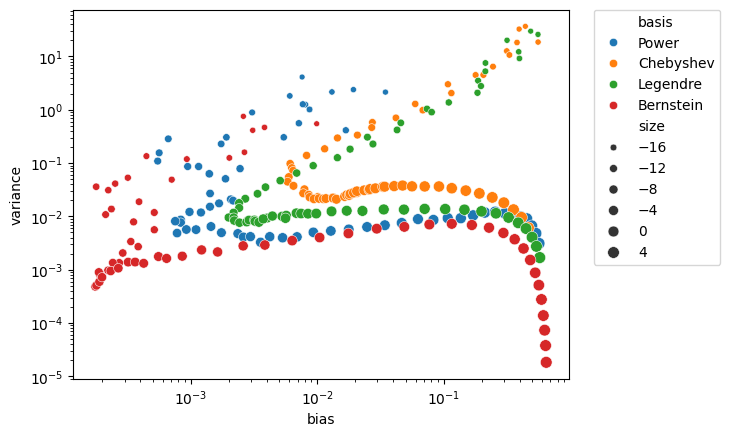

In [88]:
to_plot = all_df.copy()
to_plot['size'] = np.log(to_plot['reg_coef'])

sns.scatterplot(data=to_plot, x='bias', y='variance', hue='basis', size='size')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
plt.show()

# Define increasing function to fit

In [89]:
def nonneg_poly(half_deg):
  ''' SOS polynomial of degree 2d '''
  num_coef = 1 + half_deg
  first_poly = Polynomial(np.random.standard_cauchy(num_coef))
  second_poly = Polynomial(np.random.standard_cauchy(num_coef))
  return first_poly * first_poly + second_poly * second_poly

In [90]:
# https://zhengy09.github.io/ECE285/lectures/L13.pdf - theorem 13.3
def nonneg_on_biunit(deg):
  if deg == 0:
    return Polynomial(np.random.standard_cauchy()) ** 2
  if deg % 2 == 0: # odd degree
    s1 = nonneg_poly(deg // 2)
    s2 = nonneg_poly(deg // 2 - 1)
    return s1 + s2 * Polynomial(np.array([1, 0, -1]))
  else: # even degree
    s1 = nonneg_poly((deg - 1) // 2)
    s2 = nonneg_poly((deg - 1) // 2)
    return Polynomial(np.array([1, -1])) * s1 + \
           Polynomial(np.array([1, 1])) * s2

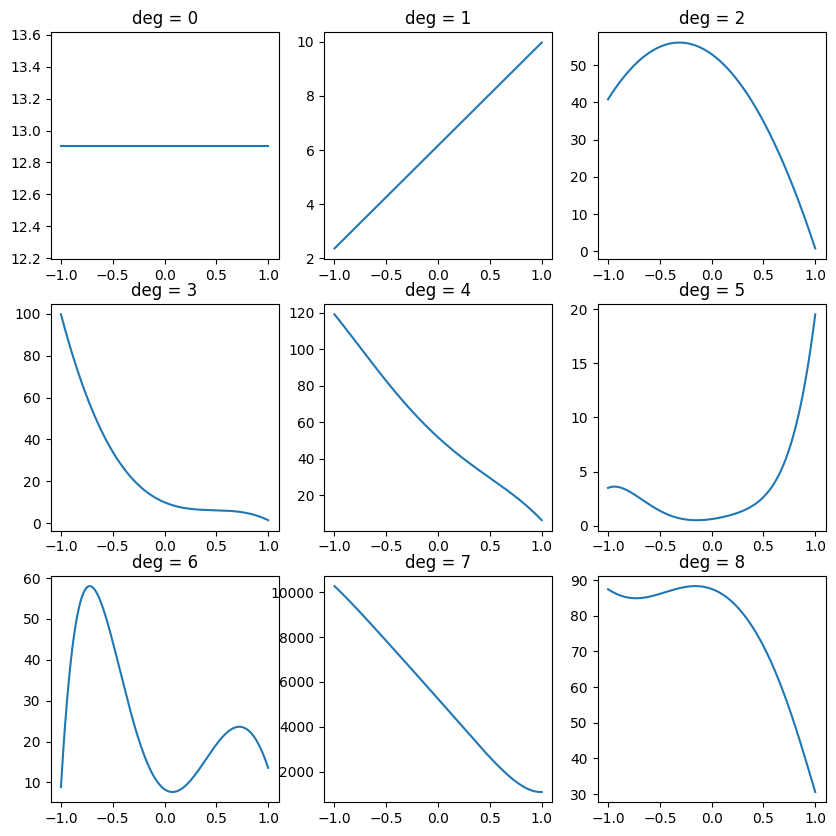

In [91]:
np.random.seed(42)
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
xs = np.linspace(-1, 1, 1000)
for deg, ax in enumerate(ax.flatten()):
  ys = nonneg_on_biunit(deg)(xs)
  ax.plot(xs, ys)
  ax.set_title(f'deg = {deg}')
plt.show()

In [92]:
def increasing_on_biunit(deg):
  nonneg = nonneg_on_biunit(deg - 1)
  return nonneg.integ()

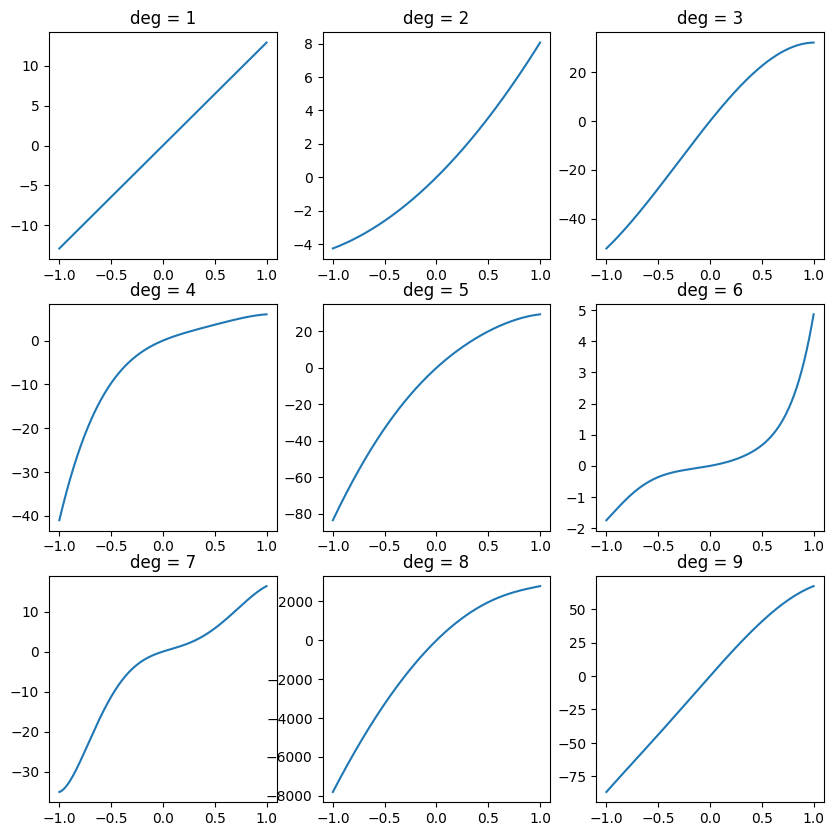

In [93]:
np.random.seed(42)
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
xs = np.linspace(-1, 1, 1000)
for deg, ax in enumerate(ax.flatten(), start=1):
  ys = increasing_on_biunit(deg)(xs)
  ax.plot(xs, ys)
  ax.set_title(f'deg = {deg}')
plt.show()

### Fit nondecreasing bernstein polynomial of same degree

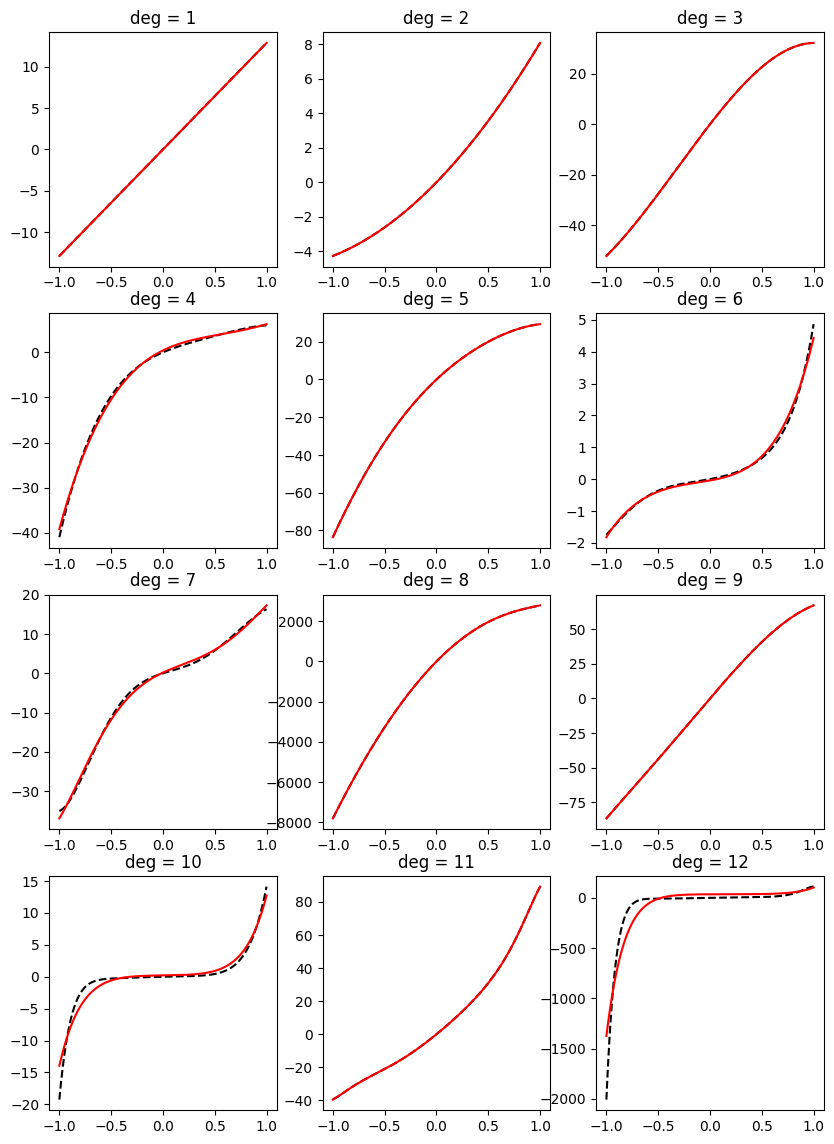

In [94]:
import cvxpy as cp

np.random.seed(42)
fig, ax = plt.subplots(4, 3, figsize=(10, 14))
xs = np.linspace(-1, 1, 1000)
for deg, ax in enumerate(ax.flatten(), start=1):
  true_ys = increasing_on_biunit(deg)(xs)

  vander_mat = bernvander(xs, deg)
  coef_var = cp.Variable(1 + deg)
  objective = cp.Minimize(cp.sum_squares(vander_mat @ coef_var - true_ys))
  prob = cp.Problem(objective, constraints=[cp.diff(coef_var) >= 0])
  prob.solve()

  coef = coef_var.value
  bern_ys = bernvander(xs, deg) @ coef

  ax.plot(xs, true_ys, 'k--')
  ax.plot(xs, bern_ys, 'r')
  ax.set_title(f'deg = {deg}')
plt.show()

# Fit nondecreasing polynomial of a higher degree

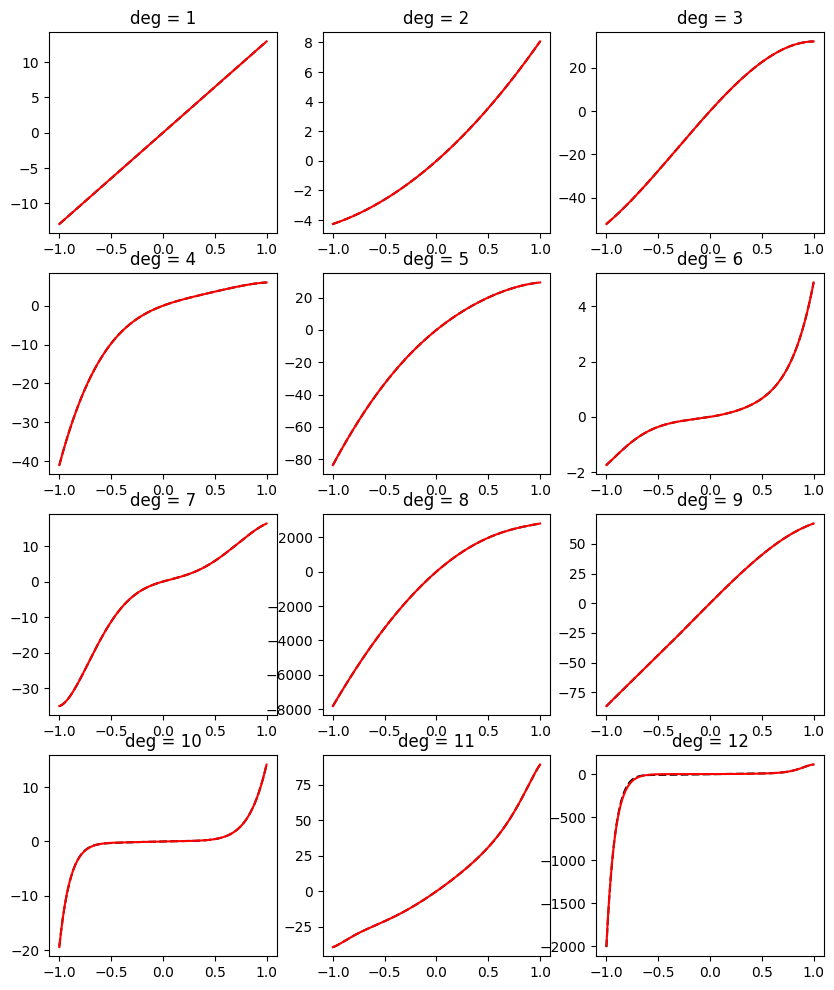

In [95]:
import cvxpy as cp

np.random.seed(42)
fig, ax = plt.subplots(4, 3, figsize=(10, 12))
xs = np.linspace(-1, 1, 1000)
for deg, ax in enumerate(ax.flatten(), start=1):
  true_ys = increasing_on_biunit(deg)(xs)

  fit_deg = 2 * deg
  vander_mat = bernvander(xs, fit_deg)
  coef_var = cp.Variable(1 + fit_deg)
  objective = cp.Minimize(cp.sum_squares(vander_mat @ coef_var - true_ys))
  prob = cp.Problem(objective, constraints=[cp.diff(coef_var) >= 0])
  prob.solve()

  coef = coef_var.value
  bern_ys = bernvander(xs, fit_deg) @ coef

  ax.plot(xs, true_ys, 'k--')
  ax.plot(xs, bern_ys, 'r')
  ax.set_title(f'deg = {deg}')
plt.show()